# The Arena
The Arena has any two players compete and takes the score. The idea: Once the challenger wins it becomes the new champion and will produce the next generation of selfplay data to train its upcoming challenger with.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from aegomoku.gomoku_game import GomokuGame
from aegomoku.arena import Arena
from aegomoku.interfaces import MctsParams, PolicyParams
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from pathlib import Path

2022-09-16 18:16:00.791526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from aegomoku.gomoku_game import RandomBoardInitializer, Swap2, TopoSwap2BoardInitializer
from aegomoku.policies.topological_value import TopologicalValuePolicy

BOARD_SIZE = 19
s2bi = TopoSwap2BoardInitializer(BOARD_SIZE)
the_game = Swap2(BOARD_SIZE, initializer=None)

model_file = Path('../DATA/models' ) / '1_c3.model'
mcts_challenger = MctsParams(cpuct=4.0, temperature=0, num_simulations=200)
policy_challenger = PolicyParams(model_file_name=None, advice_cutoff=.01)
advisor = TopologicalValuePolicy(board_size=BOARD_SIZE)
player1 = PolicyAdvisedGraphSearchPlayer("Heuristic1", the_game, mcts_challenger, policy_params=None, adviser=advisor)

mcts_champion = MctsParams(cpuct=4.0, temperature=0, num_simulations=200)
policy_champion = PolicyParams(model_file_name=None, advice_cutoff=.01)
advisor = TopologicalValuePolicy(board_size=BOARD_SIZE)
player2 = PolicyAdvisedGraphSearchPlayer("Heuristic2", the_game, mcts_champion, policy_params=None, adviser=advisor)

In [14]:
arena = Arena(game=the_game, player1=player1, player2=player2, max_moves=4)

In [15]:
arena.play_game(verbose=2)

Heuristic1 to begin with 0.


In [6]:
arena_file = Path("../DATA") / 'arena' / '1_c3.arena'

In [7]:
stats = arena.play_games(2, verbose=1, save_to=arena_file)

Game 1: Candidate 1_c3 to begin with black.
Draw after 4 moves.
[J10, K10, J8, K12, J11, J9, K9, I8]
Game 2: Heuristic to begin with black.
Draw after 4 moves.
[J10, H11, J9, K10, J11, J8, J13, J12]
Saved gameplay data to ../DATA/arena/1_c3.arena


In [8]:
stats

{Candidate 1_c3: 0, Heuristic: 0, 'draws': 2}

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


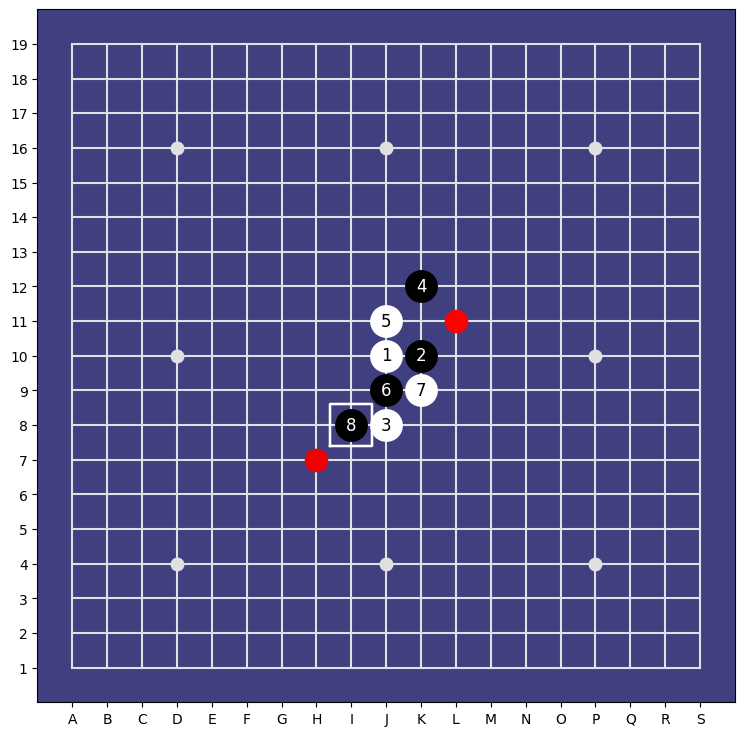

In [10]:
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.utils import analyse_board
moves = arena.games[0]
heuristics = HeuristicPolicy(BOARD_SIZE, cut_off=0.1)
analyse_board(BOARD_SIZE, moves, heuristics, disp_width=9)